Guided Diffusion with logp with
- Refactored code
- Plug and play bayesopt for testing

Section #1. Basic boilerplate for guided diffusion (loading model, data, etc.)

Section #2 Bayesopt definitions

Section #3 Bayesopt

In [1]:
# # Clear cache

# import sys

# modules_to_delete = [key for key in sys.modules.keys() if key.startswith('gdutil')]
# for module in modules_to_delete:
#     del sys.modules[module]

# import torch
# torch.cuda.empty_cache()
# if torch.cuda.is_available():
#     torch.cuda.synchronize()
    
# # For some reason my cache of saved modules won't clear unless I do this

In [ ]:
# Imports
import gdutil # utility functions for guided diffusion
import gdiffusion # my guided diffusion model

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# math util
import math
import numpy as np

# data loading / training util
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# molecules
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors
from gdutil.logp import LogPPredictor

# stats
from scipy import stats

# bayesopt
import gpytorch
from dataclasses import dataclass
from botorch.optim import optimize_acqf
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll_torch
from botorch.acquisition import qLogExpectedImprovement, LogExpectedImprovement
from gpytorch.mlls import PredictiveLogLikelihood, ExactMarginalLogLikelihood

from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from botorch.models.approximate_gp import SingleTaskVariationalGP
from botorch.models import SingleTaskGP
from gpytorch.priors import LogNormalPrior
from botorch.utils.transforms import normalize, unnormalize
from torch.optim import SGD



# Device:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")



/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [49]:
# Loads the VAE. VAE functions can be accessed with gdutil.(function_here)
VAE_LOCATION = "molformers/saved_models/epoch=447-step=139328.ckpt"
vae = gdutil.load_vae_selfies(VAE_LOCATION).to(device)

# Vae helpers:

def latent_to_logp(z, vae=vae, invalid_token=0.0):
    '''
        Converts the latent given to a logp value. Returns logp = 0 if 
        molecule cannot be parsed by defaulted
    '''

    if z.device != vae.device:
        vae.to(z.device)

    selfies = gdutil.latent_to_selfies(z=z, vae=vae)
    smiles = selfies_to_smiles(selfies)

    return evaluate_logp(smiles=smiles, invalid_token=invalid_token)

def latent_to_smiles(z, vae=vae):
    smiles = selfies_to_smiles(gdutil.latent_to_selfies(z, vae=vae))
    return smiles

loading model from molformers/saved_models/epoch=447-step=139328.ckpt
Enc params: 1,994,592
Dec params: 277,346


In [4]:
# Diffusion model
DIFFUSION_MODEL_LOCATION = "train/saved_models/modelv2-200.pt"
diffusion = gdiffusion.create_diffusion_model()
diffusion_model_data = torch.load(DIFFUSION_MODEL_LOCATION)
diffusion.load_state_dict(diffusion_model_data['model'])
diffusion.to(device)


Model created successfully
- Total parameters: 57,314,049
- Trainable parameters: 57,314,049
- Model size: 218.6 MB
- Device: cuda:0
- Model Name: GaussianDiffusion1D


GaussianDiffusion1D(
  (model): Unet1D(
    (init_conv): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (time_mlp): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=128, out_features=512, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (block1): Block(
            (proj): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
            (norm): RMSNorm()
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
            (norm): RMSNorm()
            (act): SiLU()
          )
          (res_conv): Identity()
        )
        (2): Residual(
          (fn): PreN

In [5]:
# Other Imports

# Imports a really bad logp predictor for guided diffusion
logp_predictor : LogPPredictor = torch.load(f="data/model-logp", weights_only=False).to(device)

In [6]:
# Cached sample from diffusion model to compare with
z_diffusion = diffusion.sample(batch_size=64)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 1000/1000 [00:21<00:00, 46.73it/s]


In [7]:
# Guided diffusion util

# A condition function (abreviated cond_fn) has a signature cond_fn(z, t, **kwargs)
# where z is a tensor of shape (B, 1, 128), t is a time between 0 and 1000 and **kwargs
# are any parameters. 

# the cond_fn returns the gradient of the log probability with respect to z. To make this easier
# to plug and play, you simply drop in a log_probability_function which computed the log_prob
# and this wrapper does  the rest.

def get_cond_fn(log_prob_fn, guidance_strength: float = 1.0, latent_dim: int = 128, clip_grad=False, clip_grad_max=10.0, debug=False):
    '''
        log_prob_fn --> maps a latent z of shape (B, 128) into a log probability
        guidance_strength --> the guidance strength of the model
        latent_dim --> the latent dim (always 128)
        clip_grad --> if the model should clip the gradient to +-clip_grad_max

        Returns a cond_fn that evaluastes the grad of the log probability
    '''

    def cond_fn(mean, t, **kwargs):
        # mean.shape = (B, 1, 128), so reshape to (B, 128) so predicter can handle it
        mean = mean.detach().reshape(-1, latent_dim)
        mean.requires_grad_(True)

        # if debug:
            # print(f"mean: {mean}")
            # print(f"mean.shape: {mean.shape}")
            # print(f"mean.requires_grad: {mean.requires_grad}")


        #---------------------------------------------------------------------------

        with torch.enable_grad():
            predicted_log_probability = log_prob_fn(mean)
            if debug:
                print(f"pred_log_prob: {predicted_log_probability}")
                print(f"pred_log_prob.shape: {predicted_log_probability.shape}")
                print(f"pred_log_prob.requires_grad {predicted_log_probability.requires_grad}")
                
            gradients = torch.autograd.grad(predicted_log_probability, mean, retain_graph=True)[0]

            # if debug:
                # print(f"gradients: {gradients}")
                # print(f"graidents.shape: {gradients.shape}")
                # print(f"gradients.requires_grad {gradients.requires_grad}")
                
            if clip_grad:
                if debug:
                    print(f"Clipping gradients to {-clip_grad_max} to {clip_grad_max}")
                gradients = torch.clamp(gradients, -clip_grad_max, clip_grad_max)
                
            grads = guidance_strength * gradients.reshape(-1, 1, latent_dim)
            if debug:
                # print(f"grads: {grads}")
                print(f"grad_norm: {grads.norm(2)}")
                print(f"grads.shape: {grads.shape}")
                # print(f"grads.requires_grad {grads.requires_grad}")
                
            return grads
        
    return cond_fn


# Visualizes the latent space
def plot_latent(latent):
    latent = latent.cpu()
    latent_reshaped = torch.reshape(latent, shape = (8, 16))
    plt.figure(figsize=(8, 10))
    plt.imshow(latent_reshaped, cmap='viridis')

    # Add values to each cell
    for i in range(8):
        for j in range(16):
            plt.text(j, i, f'{latent_reshaped[i,j]:.2f}', 
                    ha='center', va='center', color='white')

    plt.title(label=f"Max Value: {latent.max()}  Min Value: {latent.min()}")
    plt.colorbar()
    plt.show()

# Tells you if your latent batch z is different from the VAE prior, which is similar to 
# just sampling from the diffusion


# Even simpler version if you already have random samples
def is_different_from_diffusion(z, alpha=0.05):
    guided_flat = z.flatten().detach().cpu().numpy()
    baseline_flat = z_diffusion.flatten().detach().cpu().numpy()
    
    # KS test
    _, p_value = stats.ks_2samp(guided_flat, baseline_flat)
    

    print(f"Sample of shape: {z.shape} is {'' if p_value < alpha else 'not '}different from diffusion with p={p_value:.4f}")
    return p_value < alpha, p_value

def is_different_from_other(z, z_other, alpha=0.05):
    guided_flat = z.flatten().detach().cpu().numpy()
    baseline_flat = z_other.flatten().detach().cpu().numpy()
    
    # KS test
    _, p_value = stats.ks_2samp(guided_flat, baseline_flat)
    
    print(f"Sample of shape: {z.shape} is {'' if p_value < alpha else 'not '}different from other with p={p_value:.4f}")
    return p_value < alpha, p_value

def plot_histograms(array_list, label_list):
    plt.figure(figsize=(10, 6))

    color_list = ['red', 'blue', 'green', 'yellow', 'pink', 'purple']
    for array, label, color in zip(array_list, label_list, color_list):
        plt.hist(array, alpha=0.7, label=label, density=True, color=color)

    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Logps')
    plt.legend()
    plt.show()

def display_logp_info(z, show_histogram=True, show_molecule=True):
    # LogPs 
    prev_dtype = vae.dtype
    vae.to(z.dtype)
    logps_gd = latent_to_logp(z)
    z_vae = torch.randn(64, 128)
    logps_vae = latent_to_logp(z_vae) # sample from VAE prior
    logps_diffusion_cached = latent_to_logp(z_diffusion)
    vae.to(prev_dtype)

    if show_histogram:
        plot_histograms([logps_gd, logps_vae, logps_diffusion_cached], ['Guided Diffusion LogPs', 'VAE Prior LogPs', 'Cached Diffusion LogPs'])

    # Example of one of the guided diffusion moleculee:
    if show_molecule:
        smiles_gd = latent_to_smiles(z)
        gdutil.display_molecule(smiles_string=smiles_gd[0], title='Guided Diffusion Output')

    # you would not believe me but I actually wrote this not claude for once lmao

    print(f"Max LogP: {max(logps_gd)}")
    print(f"Min LogP: {min(logps_gd)}")
    print(f"Avg LogP: {sum(logps_gd) / len(logps_gd)}")

    print("--------------------------------------------------")
    print("Statistics: ")
    is_different_from_diffusion(z)

sampling loop time step: 100%|██████████| 1000/1000 [00:11<00:00, 87.32it/s]


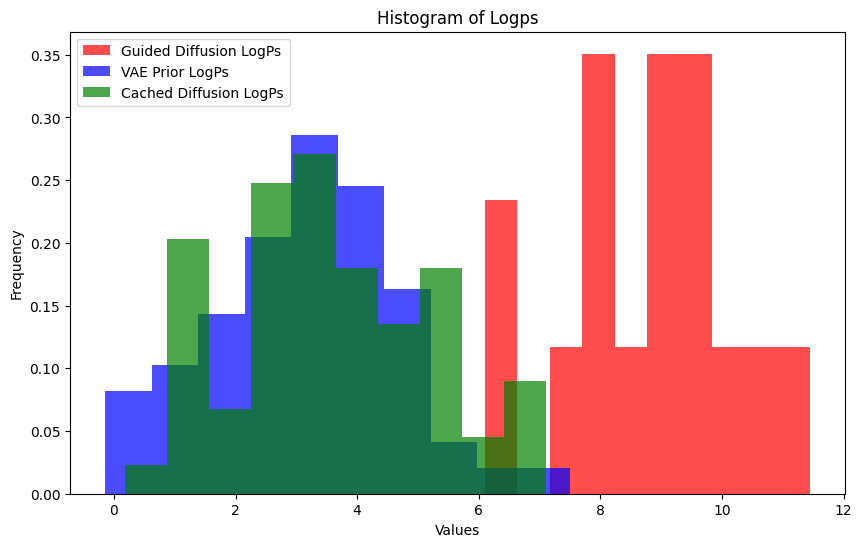

RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double

In [10]:
# Tests to check if guided diffusion is working
do_diffusion_tests = True
vae = vae.double().to(device)

def get_cond_fn_normal_analytical(mean=0.0, sigma=0.001):
    # analytically computes the gradient of the log probability under
    # a normal distribution with mean=mean, sigma=sigma

    def cond_fn(z, t, **guidance_kwargs):
        z = z.to(device)
        grad = -(z - mean) / (sigma**2)

        # MUST clamp gradient for numerical stability
        # It is REALLY finnicky about how much you clamp
        # not ideal really...

        grad = torch.clamp(grad, min=-100.0, max=100.0)
        return grad
    
    return cond_fn

def _diffusion_test_one():
    # Test 1. Get all of the latent values to be 0.5
    # -------------------------------------------------

    cond_fn_normal_dist = get_cond_fn_normal_analytical(mean=-0.5, sigma=0.01)
    z = diffusion.sample(batch_size=16, cond_fn=cond_fn_normal_dist, guidance_kwargs={})

    # Should print is different from diffusion
    is_different_from_diffusion(z, alpha=0.01)

    # Should be normal centered around 0.2
    plot_latent(z[0])

# Test the shapes are working
def _diffusion_test_two():
    # Prior that the logps of my molecules should be ~20.0
    logp_distribution = Normal(loc=20.0, scale=1.0)

    # log probability function that gives the probability of the logps of z
    # under the logp_distribution

    def log_prob_fn_logp(z):
        # We cant backprop thru the evaluate_logp function, so we 
        # instead have this predictor trained on latent, logp pairs:
        pred_logp = logp_predictor(z)

        # get the log_probability under the normal distribution with mean=20.0
        log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)

        # the log probability must be a single value
        assert(log_prob.shape == (1, ))
        return log_prob
    
    z_random = torch.randn(16, 1, 128, device=device)
    cond_fn_logp = get_cond_fn(log_prob_fn=log_prob_fn_logp, guidance_strength=1.0)

    grad_log_prob = cond_fn_logp(mean = z_random, t = 0)

    # shape of grad of log prob must be equal to input shape as they
    # are added
    assert(z_random.shape == grad_log_prob.shape)
    
def _diffusion_test_three():
    # Do diffusion and inspect results
    logp_distribution = Normal(loc=100.0, scale=1.0)

    def log_prob_fn_logp(z):
        pred_logp = logp_predictor(z)
        log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)
        return log_prob

    cond_fn_logp = get_cond_fn(
        log_prob_fn=log_prob_fn_logp, 
        guidance_strength=1.0, 
        clip_grad=True, 
        clip_grad_max=1.0,
    )

    z = diffusion.sample(batch_size=16, cond_fn=cond_fn_logp, guidance_kwargs={})
    display_logp_info(z)
    

if do_diffusion_tests:
    # Test 1. Test we can force latent to an arbitrary value
    # _diffusion_test_one()

    # Test 2. Test shapes work out
    _diffusion_test_two()

    # Test 3. Get a high logP molecule with basic guided diffusion
    _diffusion_test_three()
   
    

Bayesopt Section

* Everything above was just guided diffusion, everything below here should be bayesopt stuff


In [11]:
# Loads a dataset to initialize the bayesopt
# Data is of form (latent, logp)
# Where latent is (128,) and logp is a float representing the logp value

LATENT_DATASET_LOCATION = "data/latents_pair_dataset_1"
LOGP_LABEL_DATASET_LOCATION = "data/logp_pair_dataset_1"

X_all_data = torch.load(LATENT_DATASET_LOCATION)
Y_all_data = torch.load(LOGP_LABEL_DATASET_LOCATION)


# Number of initial datapoints to initialize the GP with

num_initial_datapoints = 100
Xs = X_all_data[:num_initial_datapoints].reshape(-1, 128).to(device)
Ys = Y_all_data[:num_initial_datapoints].reshape(-1, 1).to(device)

# train_dataset = TensorDataset(X, Y)
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# inducing_point_fraction = 0.25
# inducing_points = X[int(inducing_point_fraction * num_initial_datapoints)]

def get_initial_data(num_initial_datapoints=100):
    Xs = X_all_data[:num_initial_datapoints].reshape(-1,128).clone().double().to(device)
    Ys = Y_all_data[:num_initial_datapoints].reshape(-1,1).clone().double().to(device)
    return Xs, Ys



In [12]:
vae = vae.double()

In [43]:
# ~100 data points to initialize
vae = vae.double().to(device)
obj_func = lambda smiles : evaluate_logp(smiles, invalid_token=0.0)

d = 128
bounds = torch.tensor([[-5.0] * d, [5.0] * d], device=device, dtype=torch.float64)
unit_bounds = torch.tensor([[0.0] * d, [1.0] * d], device=device, dtype=torch.float64)

class BayesOptModel:
    def __init__(self, is_normalized=False, state_dict=None):
        self.X, self.Y = get_initial_data(num_initial_datapoints=1000)
        self.is_normalized = False
        # if self.is_normalized:
        #     self.X = normalize(self.X, bounds=bounds)

        self.state_dict = None if not state_dict else state_dict
        self.model = self.get_model()

        self.optimizer = SGD([{"params": self.model.parameters()}], lr=0.025)

    def get_model(self):
        '''User-defined function which defines the model'''
        return SingleTaskGP(train_X=self.X, train_Y=self.Y)
    
    def get_ei(self):
        '''User-defined function which defines the EI function'''
        return qLogExpectedImprovement(self.model, best_f=self.Y.max())

    def get_mll(self):
        '''User-defined function which defines the MLL function'''
        return ExactMarginalLogLikelihood(self.model.likelihood, self.model)
    
    def fit_inital(self, num_epochs=100):
        self._fit_model(num_epochs=num_epochs)
        self.state_dict = self.model.state_dict()

    def train(self, num_epochs=10, initial_fit_num_epochs=100, model_fit_num_epochs=10, acqf_batch_size=10):
        # initial fitting
        self.fit_inital(initial_fit_num_epochs)
        
        for epoch in range(num_epochs):
            self.model = self.get_model()

            if self.state_dict is not None:
                self.model.load_state_dict(self.state_dict)

            self._fit_model()
            
            X_next = self._generate_batch(batch_size=acqf_batch_size, num_restarts=5, raw_samples=128, sequential=True)
            X_next_unormalized = unnormalize(X_next, bounds=bounds) if self.is_normalized else X_next

            # X_next_unormalized = self._generate_batch_diffusion(batch_size=acqf_batch_size)
            Y_next_list = latent_to_logp(X_next_unormalized, vae=vae, invalid_token=0.0)
            Y_next = torch.tensor(Y_next_list, dtype=self.Y.dtype, device=device).reshape(-1, 1)

            # X_next = normalize(X_next_unormalized, bounds=bounds)
            self.X = torch.cat([self.X, X_next])
            self.Y = torch.cat([self.Y, Y_next])

            self.state_dict = self.model.state_dict()


            print(f"{len(self.X)}) Best value: {self.Y.max():.5f}")

    def guide_diffusion(self):
        self.model = self.get_model()

        if self.state_dict is not None:
            self.model.load_state_dict(self.state_dict)

        X_next_unorm = self._generate_batch_diffusion(batch_size=4)

        Y_next_list = latent_to_logp(X_next_unorm, vae=vae, invalid_token=0.0)
        Y_next = torch.tensor(Y_next_list, dtype=self.Y.dtype, device=device).reshape(-1, 1)
        print(f"Batch Max: {Y_next.max()}")
        print(f"Batch Mean: {Y_next.mean()}")
        print(f"Batch Min: {Y_next.min()}")


    def _fit_model(self, num_epochs=10, show_epoch_num=False):
        mll = self.get_mll()
        self.model.train()

        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            output = self.model(self.X)
            loss = -mll(output, self.model.train_targets)
            loss.backward()

            if (epoch + 1) % 10 == 0 and show_epoch_num:
                print(f"Epoch {epoch+1:>3}/{10} - Loss: {loss.item():>4.3f} ")

            self.optimizer.step()

    def _update_model(self):
        pass

    def _get_qei_fn(self, best=None):
        with torch.no_grad():
            best_f = self.Y.max() if best is None else best
            EI = qLogExpectedImprovement(self.model, best_f=best_f)

        # probably should be under
        def log_probability_fn_with_ei(mean):
            mean = mean.to('cuda')
            # mean is unnormalized:
            mean = normalize(mean, bounds=bounds)
            ei_val = EI(mean)
            return ei_val
        return log_probability_fn_with_ei
    
    def _get_ei_fn(self, best=None):
        with torch.no_grad():
            best_f = self.Y.max() if best is None else best
            EI = LogExpectedImprovement(self.model, best_f=best_f)

        def log_probability_fn_with_ei(mean):
            mean = mean.to('cuda')
            # mean = normalize(mean, bounds=bounds)
            ei_val = EI(mean.reshape(-1, 1, 128)).sum()
            return ei_val
        return log_probability_fn_with_ei

    def _generate_batch(self, batch_size=10, num_restarts=10, raw_samples=512, sequential=True):
        print("Generating Batch...")
        ei = self.get_ei()

        acqf_bounds = unit_bounds if self.is_normalized else bounds
        X_next, acq_value = optimize_acqf(
            ei,
            q=batch_size,
            bounds=acqf_bounds,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
            sequential=sequential
        )
        
        return X_next
    
    def _generate_batch_diffusion(self, batch_size=4, guidance_strength=1.0):
        # return torch.randn(batch_size, 128, dtype=torch.float64, device=device)
        z = diffusion.sample(batch_size=batch_size, cond_fn=get_cond_fn(log_prob_fn=self._get_qei_fn(best=0.0), guidance_strength=10.0), guidance_kwargs={})
        z = z.double().reshape(-1, 128).to(device)
        return z


In [44]:
bayesopt = BayesOptModel()

/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


In [45]:
bayesopt.train()

Generating Batch...


/opt/conda/lib/python3.10/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


1010) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...
1020) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...
1030) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...
1040) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...


/opt/conda/lib/python3.10/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


1050) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...


/opt/conda/lib/python3.10/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


1060) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...
1070) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...


/opt/conda/lib/python3.10/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


1080) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...
1090) Best value: 15.69320


/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Generating Batch...


/opt/conda/lib/python3.10/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


1100) Best value: 15.69320


In [47]:
bayesopt_model = bayesopt.get_model()
bayesopt_model.load_state_dict(bayesopt.state_dict)

cond_fn = get_cond_fn(log_prob_fn=bayesopt._get_ei_fn(best=10.0), guidance_strength=1000.0, debug=False)

/opt/conda/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


In [48]:
z = diffusion.sample(batch_size=16, cond_fn=cond_fn, guidance_kwargs={})

z = z.double().reshape(-1, 128).to(device)
Y_next_list = latent_to_logp(z, vae=vae, invalid_token=0.0)
Y_next = torch.tensor(Y_next_list, dtype=bayesopt.Y.dtype, device=device).reshape(-1, 1)
print(f"Batch Max: {Y_next.max()}")
print(f"Batch Mean: {Y_next.mean()}")
print(f"Batch Min: {Y_next.min()}")


sampling loop time step: 100%|██████████| 1000/1000 [00:17<00:00, 58.64it/s]


Batch Max: 6.713300000000006
Batch Mean: 3.933060625000003
Batch Min: 0.24810000000000026


In [705]:
_, top_k_indices = torch.topk(bayesopt.Y.squeeze(), 5)

# Select the corresponding X and Y values
best_X = bayesopt.X[top_k_indices]
best_Y = bayesopt.Y[top_k_indices]

In [706]:
ei = bayesopt._get_ei_fn(best=3.0)
# smiles = latent_to_smiles(unnormalize(best_X, bounds=bounds))
# print(best_X)
# gdutil.display_molecule(smiles[0], title="logP = {best_Y[0]}")
print(f"Best_EI: {ei(perma)}")
print(f"Random EI: {ei(torch.rand(4, 128))}")


Best_EI: -1.6294844826222776
Random EI: -4.100125247888614


In [ ]:
# # Turbo

# @dataclass
# class TurboState:
#     dim: int
#     batch_size: int
#     length: float = 0.8
#     length_min: float = 0.5 ** 7
#     length_max: float = 1.6
#     failure_counter: int = 0
#     failure_tolerance: int = 5  
#     success_counter: int = 0
#     success_tolerance: int = 10  # Note: The original paper uses 3
#     best_value: float = -float("inf")
#     restart_triggered: bool = False

# def update_state(state, Y_next):
#     if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
#         state.success_counter += 1
#         state.failure_counter = 0
#     else:
#         state.success_counter = 0
#         state.failure_counter += 1

#     if state.success_counter == state.success_tolerance:  # Expand trust region
#         state.length = min(2.0 * state.length, state.length_max)
#         state.success_counter = 0
#     elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
#         state.length /= 2.0
#         state.failure_counter = 0

#     state.best_value = max(state.best_value, max(Y_next).item())
#     if state.length < state.length_min:
#         state.restart_triggered = True
#     return state

# def generate_batch_turbo(
#     state,
#     model,  # GP model
#     X,  # Evaluated points
#     Y,  # Function values
#     batch_size,
#     num_restarts=10,
#     raw_samples=512,
#     absolute_bounds=None,
#     n_candidates=None,
#     acqf="ts",
# ):
    
#     x_center = X[Y.argmax(), :].clone()
#     tr_lb = x_center - 3 * state.length
#     tr_ub = x_center + 3 * state.length

#     ei = qLogExpectedImprovement(model, Y.max())
#     X_next, acq_value = optimize_acqf(
#         ei,
#         bounds=torch.stack([tr_lb, tr_ub]),
#         q=batch_size,
#         num_restarts=num_restarts,
#         raw_samples=raw_samples,
#     )
    
#     return X_next


# state = TurboState(dim=128, batch_size=1)
# print(Y.min(), Y.max())

# likelihood = GaussianLikelihood().to(device='cuda:0')
# covar_module = ScaleKernel(MaternKernel(nu=2.5)).to(device='cuda:0')
# model = SingleTaskVariationalGP(X, Y, inducing_points=1024, likelihood=likelihood, covar_module=covar_module)

# mll = PredictiveLogLikelihood(likelihood, model.model, num_data=len(Y))
# fit_gpytorch_mll(mll)

tensor(-2.1395, device='cuda:0', dtype=torch.float64) tensor(14.5209, device='cuda:0', dtype=torch.float64)


KeyboardInterrupt: 

In [ ]:
# first_train = False
# while not state.restart_triggered:
#     # Normalize labels for GP training
#     # train_Y = (Y - Y.mean()) / Y.std()
#     # train_Y = Y
    
#     fit_gpytorch_mll(mll)
    
#     # Generate batch
#     X_next = generate_batch_turbo(
#         state=state,
#         model=model,
#         X=X,
#         Y=Y,
#         batch_size=10,
#         acqf='ei'
#     )
    
#     # Decode batch to smiles, get logP values.
#     Y_next_list = latent_to_logp(X_next, vae=vae, invalid_token=0.0)
#     Y_next = torch.tensor(Y_next_list, dtype=Y.dtype, device=device).reshape(-1, 1)

#     # update turbo state
#     state = update_state(state=state, Y_next=Y_next)

#     # add data
#     X = torch.cat([X, X_next])
#     Y = torch.cat([Y, Y_next])
    
#     print(
#         f"{len(X)}) Best value: {state.best_value:.5f}"
#     )


890) Best value: 80.46600


KeyboardInterrupt: 

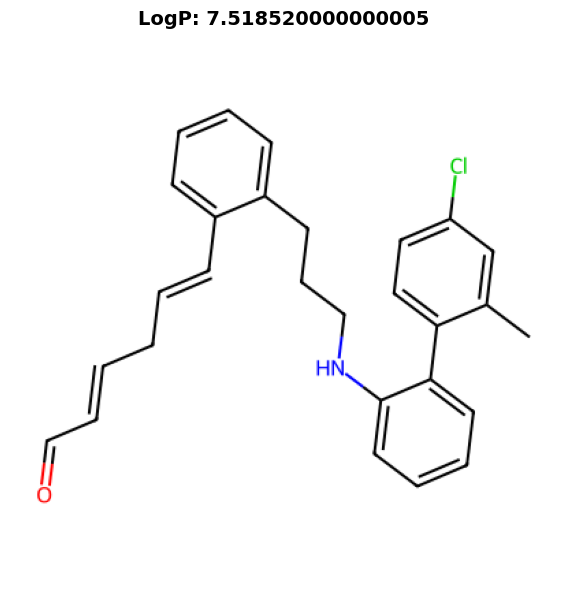

SMILES: O=CC=CCC=CC1=CC=CC=C1CCCNC2=CC=CC=C2C3=CC=C(Cl)C=C3C


In [711]:
# z_best = X[Y.argmax()]
z_best = z

smiles = latent_to_smiles(z_best, vae=vae)
logps = evaluate_logp(smiles)

idx = torch.tensor(logps).argmax()

gdutil.display_molecule(smiles[idx], title=f'LogP: {evaluate_logp(smiles)[idx]}')
